In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import random
import os

os.environ['CUDA_LAUNCH_BLOCKING'] = "1" 

import torch # import pytorch
import torch.nn as nn # pytorch's neural networks module
import torch.nn.functional as F # functional module.
import torch.optim as optim

In [3]:
import numpy as np
#change path to the path in your drive

#Shrey's file paths

#Arvind's file paths

#Richard's file paths
X_test = np.load("/content/drive/MyDrive/2023/23W/eec147/c147finalproject/X_test.npy") 
y_test = np.load("/content/drive/MyDrive/2023/23W/eec147/c147finalproject/y_test.npy")
person_train_valid = np.load("/content/drive/MyDrive/2023/23W/eec147/c147finalproject/person_train_valid.npy")
X_train_valid = np.load("/content/drive/MyDrive/2023/23W/eec147/c147finalproject/X_train_valid.npy")
y_train_valid = np.load("/content/drive/MyDrive/2023/23W/eec147/c147finalproject/y_train_valid.npy")
person_test = np.load("/content/drive/MyDrive/2023/23W/eec147/c147finalproject/person_test.npy")

In [4]:
print('Training/Valid data shape: {}'.format(X_train_valid.shape))
print('Test data shape: {}'.format(X_test.shape))
print('Training/Valid target shape: {}'.format(y_train_valid.shape))
print('Test target shape: {}'.format(y_test.shape))
print('Person train/valid shape: {}'.format(person_train_valid.shape))
print('Person test shape: {}'.format(person_test.shape))

'''
2115 training samples
443 testing samples
1000 time bins per sample
22 electrodes
11 possible labels
'''

Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


'\n2115 training samples\n443 testing samples\n1000 time bins per sample\n22 electrodes\n11 possible labels\n'

In [5]:
def data_prep(X,y,sub_sample,average,noise, device, firstn = 500):
    
    y = (y - np.min(y)).astype('int')
    total_X = None
    total_y = None
    print('Shape of X:',X.shape)
    print('Shape of y:',y.shape)
    # Trimming the data (sample,22,1000) -> (sample,22,500)
    X = X[:,:,0:firstn]
    print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,1000) -> (sample,22,500/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
     
    
    total_X = X_max
    total_y = y
    print('Shape of X after maxpooling:',total_X.shape)
    
    # Averaging + noise 
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)
    
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    print('Shape of X after averaging+noise and concatenating:',total_X.shape)
    
    # Subsampling
    
    for i in range(sub_sample):
        
        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
            
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))
        
    
    print('Shape of X after subsampling and concatenating:',total_X.shape)
    total_X = torch.FloatTensor(total_X).to(device)
    total_y = torch.LongTensor(total_y).to(device)

    return total_X,total_y
    
def to_categorical(y, num_classes):
    """ 1-hot encodes a tensor """
    return np.eye(num_classes, dtype='uint8')[y]

In [6]:
X_train_valid.shape, y_train_valid.shape

((2115, 22, 1000), (2115,))

In [7]:
X_train_valid.shape, y_train_valid.shape

((2115, 22, 1000), (2115,))

###CONV

In [8]:
print(torch.cuda.is_available())
device_id = 0 if torch.cuda.is_available() else 'cpu' # Equivalent to device_id = 'cuda:0'
device = torch.device(device_id) # use these semantics to specify a specific device. 


True


In [9]:
from sklearn.model_selection import train_test_split
X_train_np, X_val_np, y_train_np, y_val_np = train_test_split(X_train_valid, y_train_valid, test_size=0.2, random_state=12345)

X_train,y_train = data_prep(X_train_np,y_train_np,2,2,True, device)
X_val,y_val = data_prep(X_val_np,y_val_np,2,2,True, device)
X_test,y_test = data_prep(X_test,y_test,2,2,True, device)

Shape of X: (1692, 22, 1000)
Shape of y: (1692,)
Shape of X after trimming: (1692, 22, 500)
Shape of X after maxpooling: (1692, 22, 250)
Shape of X after averaging+noise and concatenating: (3384, 22, 250)
Shape of X after subsampling and concatenating: (6768, 22, 250)
Shape of X: (423, 22, 1000)
Shape of y: (423,)
Shape of X after trimming: (423, 22, 500)
Shape of X after maxpooling: (423, 22, 250)
Shape of X after averaging+noise and concatenating: (846, 22, 250)
Shape of X after subsampling and concatenating: (1692, 22, 250)
Shape of X: (443, 22, 1000)
Shape of y: (443,)
Shape of X after trimming: (443, 22, 500)
Shape of X after maxpooling: (443, 22, 250)
Shape of X after averaging+noise and concatenating: (886, 22, 250)
Shape of X after subsampling and concatenating: (1772, 22, 250)


In [10]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, X, Y):
        if isinstance(X, np.ndarray):
            self.X = torch.FloatTensor(X) # 32-bit float
        else:
            self.X = X
        if isinstance(Y, np.ndarray):
            self.Y = torch.LongTensor(Y) # integer type
        else:
            self.Y = Y
        return
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        return self.X[index], self.Y[index]

In [11]:
batch_size = 32

train_dataset = MyDataset(X_train, y_train)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True)

val_dataset = MyDataset(X_val, y_val)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size, shuffle=False)

test_dataset = MyDataset(X_test, y_test)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size, shuffle=False)

In [12]:
import tqdm

In [15]:
# from tutorial
class Conv(nn.Module):
    def __init__(self, input_shape=(22, 250), n_temporal_filters=40, n_spatial_filters=60, n_classes=4, batch_size=32, dropout=0.3):
        super().__init__() # call __init__ method of superclass
        
        self.input_shape = input_shape # last two dimensions, (excluding batch size). Should be length 2.
        self.n_temporal_filters = n_temporal_filters
        self.n_spatial_filters = n_spatial_filters
        self.n_classes = n_classes
        self.batch_size = batch_size
        self.dropout = dropout

        F = 8 #8
        D = 4 #4 
        self.conv = nn.Sequential(
          
            
            nn.Conv2d(1, F, (1, 32), padding='same'),
            nn.BatchNorm2d(F),

            nn.Conv2d(F, F*4, (1, 32), padding='same'),
            nn.BatchNorm2d(4*F),
            nn.ELU(),

            nn.Conv2d(F*4, F*D*4, (22, 1), groups=F*4),
            nn.BatchNorm2d(4*F*D),
            nn.ELU(),
            nn.AvgPool2d((1, 4)),
            nn.Dropout(0.7),

            nn.Conv2d(F*D*4, F*D*4, (1, 16), padding="same", dilation=(1, 4)),
            nn.BatchNorm2d(4*F*D),
            nn.ELU(),
            nn.AvgPool2d((1, 8)),
            nn.Dropout(0.7)

        )
        
        self.n_dense_features = n_spatial_filters*(1 + ((input_shape[1] - 25 + 1) - 75) // 15)
        self.dense = nn.Sequential(            
            nn.Linear(896, n_classes),
            #nn.Softmax()
        )
        
        return
    
    # declaring a forward method also makes the instance a callable.
    # e.g.:
    # model = ShallowConvNet()
    # out = model(x)
    def forward(self, x):
        h = x

        h = h.view(-1, 1, self.input_shape[0], self.input_shape[1])
        h = self.conv(h)
        h = h.view(h.shape[0], -1)
        
        h = self.dense(h)
        return h




In [16]:
!pip install torchinfo
from torchinfo import summary
# Only uses outputs of modules.
print(summary(Conv(), input_size=(22, 250)))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Layer (type:depth-idx)                   Output Shape              Param #
Conv                                     [1, 4]                    --
├─Sequential: 1-1                        [1, 128, 1, 7]            --
│    └─Conv2d: 2-1                       [1, 8, 22, 250]           264
│    └─BatchNorm2d: 2-2                  [1, 8, 22, 250]           16
│    └─Conv2d: 2-3                       [1, 32, 22, 250]          8,224
│    └─BatchNorm2d: 2-4                  [1, 32, 22, 250]          64
│    └─ELU: 2-5                          [1, 32, 22, 250]          --
│    └─Conv2d: 2-6                       [1, 128, 1, 250]          2,944
│    └─BatchNorm2d: 2-7                  [1, 128, 1, 250]          256
│    └─ELU: 2-8                          [1, 128, 1, 250]          --
│    └─AvgPool2d: 2-9                    [1, 128, 1, 62]           --
│    └─Dropout: 2-10                     [1, 128

In [17]:
l2_reg = 1e-4

model = Conv().to(device)
# For weight regularization, add weight_decay=l2_regularization_strength to the optimizer instantiation,
#   or implement it manually and add it to the loss before backward propagation.

# Declare an optimizer that handles weight updates
# This optimizer also has its own state dictionary
optimizer = torch.optim.Adam(model.parameters(), weight_decay=0.0005)
#scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.96)
celoss = nn.CrossEntropyLoss()

loss_hist = []
val_loss_hist = []
acc_hist = []
val_acc_hist = []

test_loss_hist = []
test_acc_hist = []

In [19]:
num_epochs = 100
CUDA_LAUNCH_BLOCKING=1

# progress bar
pbar = tqdm.tqdm(
    range(num_epochs), position=0, leave=True,
    bar_format='{l_bar}{bar:30}{r_bar}',
)
for epoch in pbar:
    model.train() # set model to training mode.
    for batch in train_dataloader:
        optimizer.zero_grad() # clear gradients of parameters that optimizer is optimizing
        x, y = batch
        # x = x.to(device) # necessary if X is not on the same device as model
        # y = y.to(device)

        out = model(x) # shape (batch_size, n_classes)
        loss = celoss(out, y) # calculate the cross entropy loss

        loss.backward() # backpropagate
        optimizer.step() # perform optimization step
        #scheduler.step()

        # IMPORTANT: DO NOT store 'loss' by itself, since it references its entire computational graph.
        # Otherwise you will run out of memory.
        # You MUST use .item() to convert to a scalar or call .detach().
        loss_hist.append(loss.item())
    
    model.eval() # set model to evaluation mode. Relevant for dropout, batchnorm, layernorm, etc.
    # calculate accuracy for training and validation sets
    ns = 0 # number of samples
    nc = 0 # number of correct outputs
    with torch.no_grad():
        for batch in train_dataloader:
            x, y = batch
            
            out = model(x)
            ns += len(y)
            nc += (out.max(1)[1] == y).detach().cpu().numpy().sum()
    acc_hist.append(nc/ns)

    ns = 0 # number of samples
    nc = 0 # number of correct outputs
    with torch.no_grad():
        for batch in val_dataloader:
            x, y = batch
            out = model(x)
            loss = celoss(out, y)
            val_loss_hist.append(loss.item())
            ns += len(y)
            nc += (out.max(1)[1] == y).detach().cpu().numpy().sum()
    val_acc_hist.append(nc/ns)

    ns = 0 # number of samples
    nc = 0 # number of correct outputs
    with torch.no_grad():
        for batch in test_dataloader:
            x, y = batch
            out = model(x)
            loss = celoss(out, y)
            test_loss_hist.append(loss.item())
            ns += len(y)
            nc += (out.max(1)[1] == y).detach().cpu().numpy().sum()
    test_acc_hist.append(nc/ns)


    # update progress bar postfix
    pbar.set_postfix({'acc': acc_hist[-1], 'val_acc': val_acc_hist[-1], 'test_acc': test_acc_hist[-1]})

    # if test_acc_hist[-1] > 0.725:
    #   break

100%|██████████████████████████████| 100/100 [09:11<00:00,  5.52s/it, acc=0.96, val_acc=0.699, test_acc=0.697]


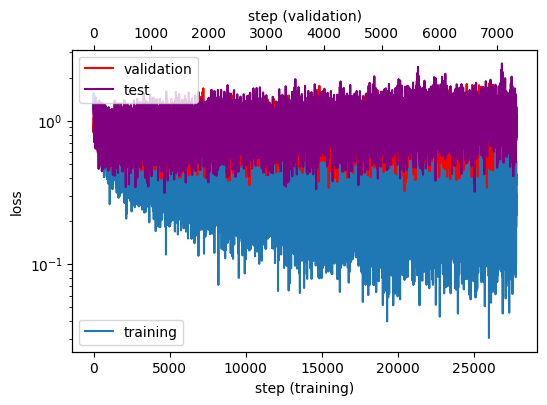

In [20]:
plt.figure(dpi=100)

plt.plot(loss_hist, label='training')
plt.yscale('log')
plt.ylabel('loss')
plt.legend(loc='lower left')
plt.xlabel('step (training)')

plt.twiny()
plt.plot(val_loss_hist, 'r', label='validation')
plt.plot(test_loss_hist, 'purple', label='test')
plt.xlabel('step (validation)')
plt.legend(loc='upper left')

In [23]:
np.max(test_acc_hist)

0.7296839729119639

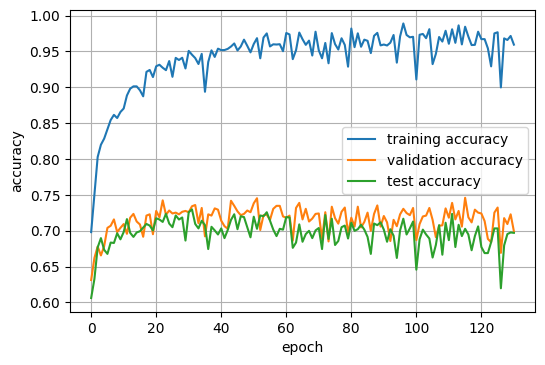

In [21]:
plt.figure(dpi=100)
plt.plot(acc_hist)
plt.plot(val_acc_hist)
plt.plot(test_acc_hist)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['training accuracy', 'validation accuracy', 'test accuracy'])
plt.grid()

In [22]:
ns = 0 # number of samples
nc = 0 # number of correct outputs
model.eval()
with torch.no_grad():
    for batch in test_dataloader:
        x, y = batch
        out = model(x)
        #print(out.max(1)[1])
        #print("---")
        #print(y)
        #loss = celoss(out, y)
        #val_loss_hist.append(loss.item())
        ns += len(y)
        nc += (out.max(1)[1] == y).detach().cpu().numpy().sum()
test_acc = nc/ns
print('Test accuracy of the hybrid CNN-LSTM model:',test_acc)

Test accuracy of the hybrid CNN-LSTM model: 0.6969525959367946


In [ ]:
for batch in val_dataloader:
  x, y = batch
  print(x)
  break

In [ ]:
for batch in test_dataloader:
  x, y = batch
  print(x)
  break

In [ ]:
#hybrid_cnn_lstm_score = model.evaluate(x_test, y_test, verbose=0)


## OPTIMISED CONVNET

(CONV RELU CONV RELU MAXPOOL)x2 AFFINE RELU AFFINE SOFTMAX

In [ ]:
# from tutorial
class ShallowConvNet(nn.Module):
    def __init__(self, input_shape=(22, 1000), n_temporal_filters=40, n_spatial_filters=40, n_classes=4):
        super().__init__() # call __init__ method of superclass
        
        self.input_shape = input_shape # last two dimensions, (excluding batch size). Should be length 2.
        self.n_temporal_filters = n_temporal_filters
        self.n_spatial_filters = n_spatial_filters
        self.n_classes = n_classes

        # https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)
        self.temporal_convolution = nn.Conv2d(1, n_temporal_filters, (1, 25))

        # We could implement the spatial convolution as a 1d, or 2d, or 3d convolution.
        # We use 2d here.
        self.spatial_convolution = nn.Conv2d(n_temporal_filters, n_spatial_filters, (input_shape[0], 1))

        self.average_pool = nn.AvgPool2d((1, 75), stride=(1, 15))
        
        # Final linear layer
        self.n_dense_features = n_spatial_filters*(1 + ((input_shape[1] - 25 + 1) - 75) // 15)
        self.dense = nn.Linear(self.n_dense_features, n_classes)
        # you can also use 'self.dense = nn.LazyLinear(n_classes)' to avoid having to manually compute features

        self.elu = nn.ELU()
        return
    
    # declaring a forward method also makes the instance a callable.
    # e.g.:
    # model = ShallowConvNet()
    # out = model(x)
    def forward(self, x):
        # x has shape (batch_size, input_shape[0], input_shape[1])
        # Let H0 = input_shape[0], H1 = input_shape[1]
        h = x

        # note that h.view(-1, 1, h.shape[1], h.shape[2]) works normally but does not work with torchinfo
        # this is because the torchinfo input has a weird shape
        h = h.view(-1, 1, self.input_shape[0], self.input_shape[1]) # view as (batch_size, 1, input_shape[0], input_shape[1])
        # Sometimes, view doesn't work and you have to use reshape. This is because of how tensors are stored in memory.
        
        # 2d convolution takes inputs of shape (batch_size, num_channels, H, W)
        h = self.temporal_convolution(h) # (batch_size, 1, H0, W0) -> (batch_size, n_temporal_filters, H0, W0 - 25 + 1)
        h = self.elu(h)

        h = self.spatial_convolution(h) # (batch_size, n_temporal_filters, H0, W0 - 25 + 1) -> (batch_size, n_spatial_filters, 1, W0 - 25 + 1)
        h = self.elu(h)

        h = h**2 # square
        # alternatively, use torch.pow(h, 2.0)

        h = self.average_pool(h) # (batch_size, n_spatial_filters, 1, W0 - 25 + 1) -> (batch_size, n_spatial_filters, 1, 1 + ((W0 - 25 + 1) - 75)//15)

        h = torch.log(h) # (natural) log

        h = h.view(h.shape[0], -1) # flatten the non-batch dimensions
        h = self.dense(h) # (batch_size, self.n_dense_features) -> (batch_size, n_classes)

        return h